In [3]:
from track_linearization import make_track_graph, plot_track_graph,get_linearized_position
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

In [8]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


# import pf_recombine_central as pfrc
# import fr_map_one_session as fmos
# import switch_detection_one_session as sdos
# import get_all_switch_add_metrics as gasam

# import preprocess_one_session as prepos

In [9]:
import matplotlib
matplotlib.rcParams['svg.fonttype']='none'
matplotlib.rcParams['font.size']=10

In [11]:
# figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/supp_figure_stable_recording'
# figdir_supp = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_variability_axis/supp'
# misc.get_or_create_subdir(figdir)
# misc.get_or_create_subdir(figdir_supp)

data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)

'/mnt/home/szheng/ceph/place_variability/data/paper'

In [12]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']
fr_map_trial_df_pyr_combined_all = prepped_data_agg['fr_map_trial_df_pyr_combined_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']
pf_params_all = prepped_data_agg['pf_params_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 


/tmp/ipykernel_3821465/3953732906.py:24: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])


In [13]:
ii=1
data_dir_full = subdb.iloc[ii]['data_dir_full']
ani=subdb.iloc[ii]['animal_name.1']
sess=subdb.iloc[ii]['sess_name']

# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses = '*SessionPulses.Events.mat',filtered='*thetaFiltered*.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
# behavior=mat_to_return['behavior']
ripples = mat_to_return['ripples']


prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
# spk_beh_df=prep_res['spk_beh_df']
cell_cols_d = prep_res['cell_cols_d']
# beh_df = prep_res['beh_df'].as_dataframe()
# beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']

ripples = mat_to_return['ripples']
ripple_events = ripples

cell_metrics=mat_to_return.cell_metrics
mergepoints = mat_to_return.mergepoints

cell_type_mask=mat_to_return['cell_type_mask']

/mnt/home/szheng/projects/util_code/data_prep_new.py:410: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(dict[key], spiomat.mio5_params.mat_struct):
/mnt/home/szheng/projects/util_code/data_prep_new.py:410: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(dict[key], spiomat.mio5_params.mat_struct):
/mnt/home/szheng/projects/util_code/data_prep_new.py:410: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(dict[key], spiomat.mio5_params.mat_struct):
/mnt/home/szheng/projects/util_code/data_prep_new.py:410: DeprecationWarning: Please import `mat_struct` from

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/mnt/home/szheng/projects/util_code/data_prep_new.py:410: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(dict[key], spiomat.mio5_params.mat_struct):
/mnt/home/szheng/projects/util_code/data_prep_new.py:410: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(dict[key], spiomat.mio5_params.mat_struct):
/mnt/home/szheng/projects/util_code/data_prep_new.py:410: DeprecationWarning: 

load *SessionPulses.Events.mat failed


/mnt/home/szheng/projects/util_code/data_prep_new.py:410: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(dict[key], spiomat.mio5_params.mat_struct):
/mnt/home/szheng/projects/util_code/data_prep_new.py:410: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(dict[key], spiomat.mio5_params.mat_struct):
/mnt/home/szheng/projects/util_code/data_prep_new.py:410: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(dict[key], spiomat.mio5_params.mat_struct):
/mnt/home/szheng/projects/util_code/data_prep_new.py:410: DeprecationWarning: Please import `mat_struct` from

In [14]:
spk_beh_df = spk_beh_df_all.loc[ani,sess]

/tmp/ipykernel_3821465/463252252.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df = spk_beh_df_all.loc[ani,sess]


In [17]:
xy

/mnt/home/szheng/ceph/envs/replay_trajectory_classification/lib/python3.11/site-packages/IPython/core/formatters.py:344: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/mnt/home/szheng/ceph/envs/replay_trajectory_classification/lib/python3.11/site-packages/IPython/core/formatters.py:344: FutureWarning: Int64Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,x,y
203,77.813737,47.715979
204,77.822900,47.884739
205,77.803383,48.183710
206,77.719991,48.587112
207,77.663467,49.099355
...,...,...
55237,91.815877,48.091953
55238,92.003157,47.895968
55239,92.219427,47.754542
55240,92.353066,47.691666


In [18]:
sns.

<module 'seaborn' from '/mnt/home/szheng/ceph/envs/replay_trajectory_classification/lib/python3.11/site-packages/seaborn/__init__.py'>

In [16]:
xy = spk_beh_df[['x','y']]
sns.histplot(data=xy,x='x',y='y')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/mnt/home/szheng/ceph/envs/replay_trajectory_classification/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3821465/2632017827.py", line 2, in <module>
    sns.histplot(data=xy,x='x',y='y')
  File "/mnt/home/szheng/ceph/envs/replay_trajectory_classification/lib/python3.11/site-packages/seaborn/distributions.py", line 1379, in histplot
    trans = tx.blended_transform_factory(ax.transData, ax.transAxes)
  File "/mnt/home/szheng/ceph/envs/replay_trajectory_classification/lib/python3.11/site-packages/seaborn/distributions.py", line 110, in __init__
  File "/mnt/home/szheng/ceph/envs/replay_trajectory_classification/lib/python3.11/site-packages/seaborn/_base.py", line 634, in __init__
  File "/mnt/home/szheng/ceph/envs/replay_trajectory_classification/lib/python3.11/site-packages/seaborn/_base.py", line 679, in assign_variables
  Fil

In [19]:
bdf=spk_beh_df
find_turns_kws_ = dict(n_lin=200,speed_key='speed_gauss',speed_thresh=10.)
corners_d,xy_sampled_d,segment_d = dpp.find_tmaze_turns(bdf,**find_turns_kws_)

/mnt/home/szheng/ceph/envs/replay_trajectory_classification/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/replay_trajectory_classification/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [20]:
corners_d

{(0,
  0.0):            x          y         lin
 0  80.722174  45.320263    0.000000
 1  10.555097  45.320263   74.655065
 2  10.555097  82.287421  111.424978
 3  80.722174  82.287421  181.622084
 4  80.722174  45.320263  221.734716,
 (0,
  1.0):            x          y         lin
 0  80.995977  45.613688    0.000000
 1  10.447895  45.613688   72.484353
 2  10.447895   9.332198  108.168465
 3  80.995977   9.332198  182.882075
 4  80.995977  45.613688  221.911572}

In [21]:
node_positions=[
    (80.8,45.4),
    (10.5,45.4),
    
    (10.5,82.3),
    (80.7,82.3),

    (10.5,9.3),
    (80.9,9.3),

]

edges = [
    (0,1),
    (1,2),
    (2,3),
    (3,0),
    (1,4),
    (4,5),
    (5,0)
]

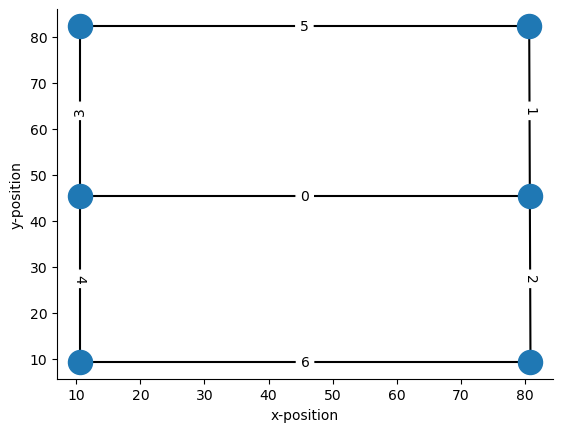

In [22]:
# node_positions = [
#     (0, 0),  # xy position of node 0
#     (30, 0),  # xy position of node 1
#     (30, 30),  # xy position of node 2
#     (0, 30),  # xy position of node 3
# ]

# edges = [
#     (0, 1),  # connects node 0 and node 1
#     (0, 3),  # connects node 0 and node 3
#     (1, 2),  # connects node 1 and node 2
# ]

track_graph = make_track_graph(node_positions, edges)

fig, ax = plt.subplots()
plot_track_graph(track_graph, ax=ax, draw_edge_labels=True)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


In [23]:
import networkx as nx
reload(nx)
nx.__version__

'3.2.1'

In [25]:
import replay_trajectory_classification

Cupy is not installed or GPU is not detected. Ignore this message if not using GPU
/mnt/home/szheng/ceph/envs/replay_trajectory_classification/lib/python3.11/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [26]:
import xarray as xr

In [34]:
position_df=get_linearized_position(xy[:1000].values,track_graph)

In [35]:
position_df

/mnt/home/szheng/ceph/envs/replay_trajectory_classification/lib/python3.11/site-packages/IPython/core/formatters.py:344: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,linear_position,track_segment_id,projected_x_position,projected_y_position
0,117.473573,14,25.980762,15.000000
1,117.473573,14,25.980762,15.000000
2,117.473573,14,25.980762,15.000000
3,117.473573,14,25.980762,15.000000
4,117.473573,14,25.980762,15.000000
...,...,...,...,...
995,125.305145,15,21.213203,21.213203
996,125.305145,15,21.213203,21.213203
997,125.305145,15,21.213203,21.213203
998,125.305145,15,21.213203,21.213203


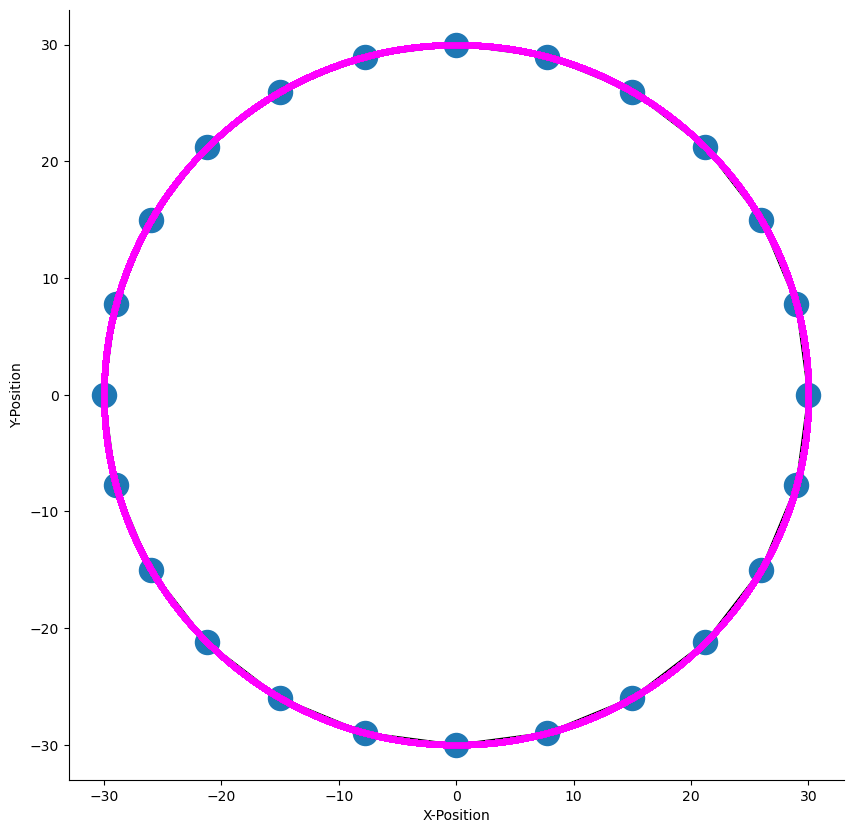

In [28]:
from replay_trajectory_classification import make_track_graph, plot_track_graph
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

angle = np.linspace(-np.pi, np.pi, num=24, endpoint=False)
radius = 30

node_positions = np.stack((radius * np.cos(angle), radius * np.sin(angle)), axis=1)

node_ids = np.arange(node_positions.shape[0])
edges = np.stack((node_ids, np.roll(node_ids, shift=1)), axis=1)

track_graph = make_track_graph(node_positions, edges)

position_angles = np.linspace(-np.pi, 31 * np.pi, num=360_000, endpoint=False)
position = np.stack((radius * np.cos(position_angles), radius * np.sin(position_angles)), axis=1)

fig, ax = plt.subplots(figsize=(10, 10))
plot_track_graph(track_graph, ax=ax)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("X-Position")
ax.set_ylabel("Y-Position")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.scatter(position[:, 0], position[:, 1], alpha=0.25, s=10, zorder=11, color="magenta")

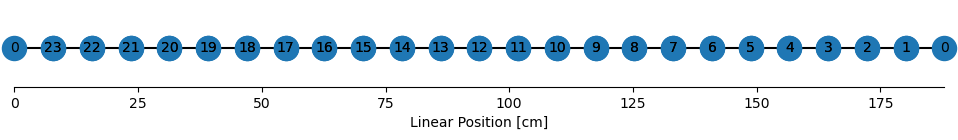

In [29]:


from replay_trajectory_classification import plot_graph_as_1D

edge_spacing = 0
n_nodes = len(track_graph.nodes)
edge_order = np.stack((np.roll(np.arange(n_nodes-1, -1, -1), 1),
                       np.arange(n_nodes-1, -1, -1)), axis=1)

fig, ax = plt.subplots(figsize=(n_nodes // 2, 1))
plot_graph_as_1D(track_graph,
                 edge_spacing=edge_spacing,
                 edge_order=edge_order,
                 ax=ax)



In [32]:
position

array([[-3.00000000e+01, -3.67394040e-15],
       [-2.99999988e+01, -8.37758030e-03],
       [-2.99999953e+01, -1.67551599e-02],
       ...,
       [-2.99999895e+01,  2.51327383e-02],
       [-2.99999953e+01,  1.67551599e-02],
       [-2.99999988e+01,  8.37758030e-03]])

In [31]:
track_graph

In [30]:
from track_linearization import get_linearized_position

position_df = get_linearized_position(position, track_graph, edge_order=edge_order, edge_spacing=edge_spacing, use_HMM=False)
position_df

/mnt/home/szheng/ceph/envs/replay_trajectory_classification/lib/python3.11/site-packages/IPython/core/formatters.py:344: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,linear_position,track_segment_id,projected_x_position,projected_y_position
0,0.000000,0,-30.000000,-3.673940e-15
1,187.949411,1,-29.998916,-8.235002e-03
2,187.941104,1,-29.997832,-1.647031e-02
3,187.932798,1,-29.996747,-2.470591e-02
4,187.924491,1,-29.995663,-3.294182e-02
...,...,...,...,...
359995,0.041533,0,-29.994579,4.117803e-02
359996,0.033226,0,-29.995663,3.294182e-02
359997,0.024919,0,-29.996747,2.470591e-02
359998,0.016612,0,-29.997832,1.647031e-02
